# Decision Tree

## Importing

In [28]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

### Evaluating Function

In [10]:
def evaluate(y_true, y_prob, titulo="Model"):
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n{titulo}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], '--')
    plt.title(f"ROC Curve - {titulo}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [21]:
df = pd.read_csv('treated_data.csv')

df = df.drop(columns=['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'Unnamed: 0'])

le = LabelEncoder()
df['types_enc'] = le.fit_transform(df['types'])


X = df.drop(['isFraud', 'types'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

## Basic Model


XGBoost - Basic
Accuracy:  0.9997
Precision:  0.8952
Recall:    0.8861
AUC-ROC:   0.9430


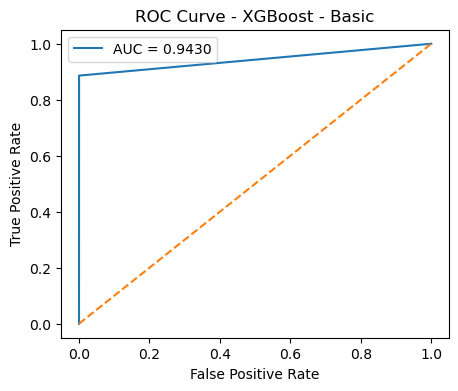

In [ ]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_basic = tree.predict_proba(X_test)[:,1]

evaluate(y_test, y_pred_basic, "Decision Tree - Basic")

## Class Weight


Decision Tree - Weight
Accuracy:  0.9997
Precision:  0.8887
Recall:    0.8577
AUC-ROC:   0.9288


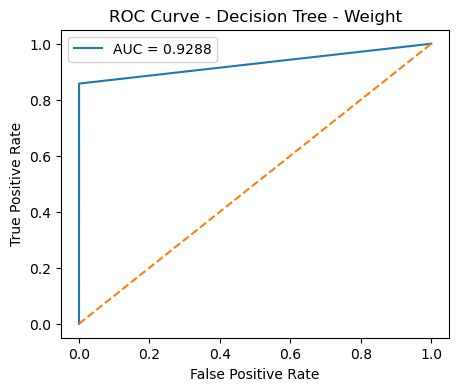

In [31]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
cw = {0: class_weights[0], 1: class_weights[1]}

tree_weighted = DecisionTreeClassifier(
    random_state=42,
    class_weight=cw
)

tree_weighted.fit(X_train, y_train)

y_prob_w = tree_weighted.predict_proba(X_test)[:, 1]


evaluate(y_test, y_prob_w, "Decision Tree - Weight")

## Undersampling


Decision Tree - Undersampling
Accuracy:  0.9966
Precision:  0.2747
Recall:    0.9841
AUC-ROC:   0.9904


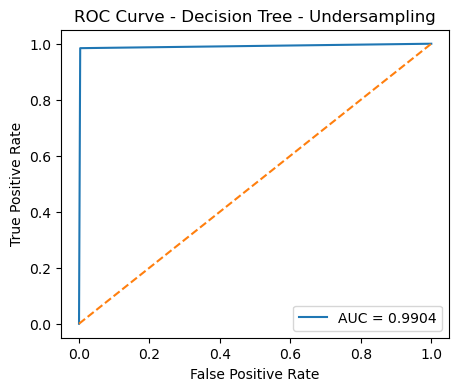

In [ ]:
train_df = X_train.copy()
train_df['isFraud'] = y_train

df0 = train_df[train_df.isFraud == 0]
df1 = train_df[train_df.isFraud == 1]

df0_under = resample(
    df0,
    replace=False,
    n_samples=len(df1) * 5, 
    random_state=42
)

train_bal = pd.concat([df0_under, df1])

X_train_b = train_bal.drop(['isFraud'], axis=1)
y_train_b = train_bal['isFraud']

tree_under = DecisionTreeClassifier(random_state=42)
tree_under.fit(X_train_b, y_train_b)

y_prob_u = tree_under.predict_proba(X_test)[:, 1]
evaluate(y_test, y_prob_u, "Decision Tree - Undersampling")